In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn import cross_validation
import sklearn.metrics
import warnings
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.formula.api as sm
%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50

First, we need to source the data relevant to the investigation, which would include things like the overall team win percentage for each team per year, home winning percentage, and location.  Unfortunately, the Lahmen baseball datasets (read about them here: http://www.seanlahman.com/baseball-archive/statistics) do not include some of the information we need like home winning percentage in their "Teams" table.  In order to get the appropriate. we'll neeed to grab multiple CSVs from another site, baseball-reference (https://www.baseball-reference.com), and transform them to yield a table with the appropriate attributes which we can start analysing. To make working with the raw CSVs easier, we'll first convert them to pandas dataframes. 

In [216]:
#load win loss tables into dataframes and drop empty rows and columns we don't need
home_wins = pd.read_csv('home_wins.csv')
team_wins = pd.read_csv('team_wins.csv')
home_wins = home_wins.dropna()
team_wins = team_wins.dropna()
home_wins = home_wins.drop(axis=1, labels=['Rk', '#Matching', 'Unnamed: 6', 'AB', 'IBB', 'HBP', 'GDP', 'SB', 'WPA', 'PA', 'SH', 'SF',
                                              '2B', '3B', 'CS'])
team_wins = team_wins.drop(axis=1, labels=['Rk', '#Matching', 'Unnamed: 6', 'AB', 'IBB', 'HBP', 'GDP', 'SB', 'WPA', 'PA', 'SH', 'SF',
                                              '2B', '3B', 'CS'])
home_wins.head()

,Tm,Year,W,L,R,H,HR,RBI,BB,SO,BA,OBP,SLG,OPS
0,TBR,2015.0,42.0,42.0,315.0,669.0,82.0,296.0,214.0,694.0,0.245,0.309,0.394,0.703
1,STL,1991.0,52.0,32.0,345.0,682.0,32.0,313.0,290.0,394.0,0.252,0.325,0.355,0.680
2,SEA,2011.0,39.0,45.0,265.0,599.0,57.0,258.0,245.0,706.0,0.222,0.289,0.333,0.623
3,PIT,1991.0,52.0,32.0,382.0,697.0,61.0,359.0,304.0,445.0,0.258,0.334,0.394,0.728
4,PHI,2010.0,54.0,30.0,410.0,747.0,94.0,397.0,282.0,495.0,0.264,0.334,0.429,0.763


The home_wins dataframe represents home wins and losses for each team per year going back to 1980, while  teams_wins represents win-loss records for teams accross all games that regular season. The CSVs were yieled through querys to the site's Play Index database.  Since baseball-reference doesn't track home win percentage explicitly, transform these tables a bit first.  First, lets calculate win percentage values for both tables and join them.

In [217]:
#Calculate percentages and merge on team name and year
home_wins['home_win_percentage'] = home_wins.apply(lambda row: row['W'] / (row['W'] + row['L']), axis=1)
team_wins['team_win_percentage'] = team_wins.apply(lambda row: row['W'] / (row['W'] + row['L']), axis=1)
#We'll drop some unnessary columns
home_wins = home_wins.drop(axis=1, labels=['W', 'L'])
team_wins = team_wins.drop(axis=1, labels=['W', 'L'])
combined_table = pd.merge(home_wins, team_wins,  how='inner', on=['Year','Tm'])
combined_table.head()

,Tm,Year,R_x,H_x,HR_x,RBI_x,BB_x,SO_x,BA_x,OBP_x,SLG_x,OPS_x,home_win_percentage,R_y,H_y,HR_y,RBI_y,BB_y,SO_y,BA_y,OBP_y,SLG_y,OPS_y,team_win_percentage
0,TBR,2015.0,315.0,669.0,82.0,296.0,214.0,694.0,0.245,0.309,0.394,0.703,0.500000,644.0,1383.0,167.0,612.0,436.0,1310.0,0.252,0.314,0.406,0.720,0.493827
1,STL,1991.0,345.0,682.0,32.0,313.0,290.0,394.0,0.252,0.325,0.355,0.680,0.619048,651.0,1366.0,68.0,599.0,532.0,857.0,0.255,0.322,0.357,0.679,0.518519
2,SEA,2011.0,265.0,599.0,57.0,258.0,245.0,706.0,0.222,0.289,0.333,0.623,0.464286,556.0,1263.0,109.0,534.0,435.0,1280.0,0.233,0.292,0.348,0.640,0.413580
3,PIT,1991.0,382.0,697.0,61.0,359.0,304.0,445.0,0.258,0.334,0.394,0.728,0.619048,768.0,1433.0,126.0,725.0,620.0,901.0,0.263,0.338,0.398,0.737,0.604938
4,PHI,2010.0,410.0,747.0,94.0,397.0,282.0,495.0,0.264,0.334,0.429,0.763,0.642857,772.0,1451.0,166.0,736.0,560.0,1064.0,0.260,0.332,0.413,0.745,0.598765


In order to clearly visualize the data and analyse trends, we should be able to express the advantage a team has when playing in their home park through a single integer.  The most natural way to calculate this number would be the difference between the win percentage at home vs the percentage in general.  We'll now take this number, multiply it by 10, and assign as the value 'home_adv' in our table.  We'll also include a similar stat for 'ba_adv'.

In [218]:
combined_table['home_adv'] = combined_table.apply(lambda row: (row['home_win_percentage'] -
                                                               row['team_win_percentage'])*100, axis=1)
combined_table['ops_adv'] = combined_table.apply(lambda row: (row['OPS_x'] - row['OPS_y'])*100, axis=1)
combined_table.head()

,Tm,Year,R_x,H_x,HR_x,RBI_x,BB_x,SO_x,BA_x,OBP_x,SLG_x,OPS_x,home_win_percentage,R_y,H_y,HR_y,RBI_y,BB_y,SO_y,BA_y,OBP_y,SLG_y,OPS_y,team_win_percentage,home_adv,ops_adv
0,TBR,2015.0,315.0,669.0,82.0,296.0,214.0,694.0,0.245,0.309,0.394,0.703,0.500000,644.0,1383.0,167.0,612.0,436.0,1310.0,0.252,0.314,0.406,0.720,0.493827,0.617284,-1.7
1,STL,1991.0,345.0,682.0,32.0,313.0,290.0,394.0,0.252,0.325,0.355,0.680,0.619048,651.0,1366.0,68.0,599.0,532.0,857.0,0.255,0.322,0.357,0.679,0.518519,10.052910,0.1
2,SEA,2011.0,265.0,599.0,57.0,258.0,245.0,706.0,0.222,0.289,0.333,0.623,0.464286,556.0,1263.0,109.0,534.0,435.0,1280.0,0.233,0.292,0.348,0.640,0.413580,5.070547,-1.7
3,PIT,1991.0,382.0,697.0,61.0,359.0,304.0,445.0,0.258,0.334,0.394,0.728,0.619048,768.0,1433.0,126.0,725.0,620.0,901.0,0.263,0.338,0.398,0.737,0.604938,1.410935,-0.9
4,PHI,2010.0,410.0,747.0,94.0,397.0,282.0,495.0,0.264,0.334,0.429,0.763,0.642857,772.0,1451.0,166.0,736.0,560.0,1064.0,0.260,0.332,0.413,0.745,0.598765,4.409171,1.8


Now, we can start plotting our data.  We'll start just by looking at the home_adv across all teams to see if there are any obvious trends or outliers

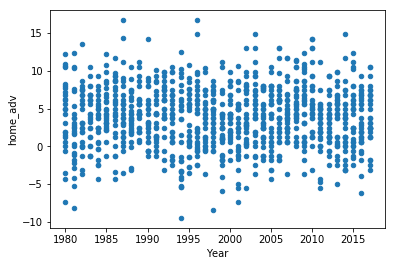

In [219]:
combined_table.plot(x='Year', y='home_adv', kind='scatter')

As one would guess, we can see that most team across the time frame had a positive home_adv, but it's hard to make out distributions and densities from the graph alone.  Let's try using a violin plot with seaborn (https://seaborn.pydata.org/generated/seaborn.violinplot.html), looking at just 5 year increments.

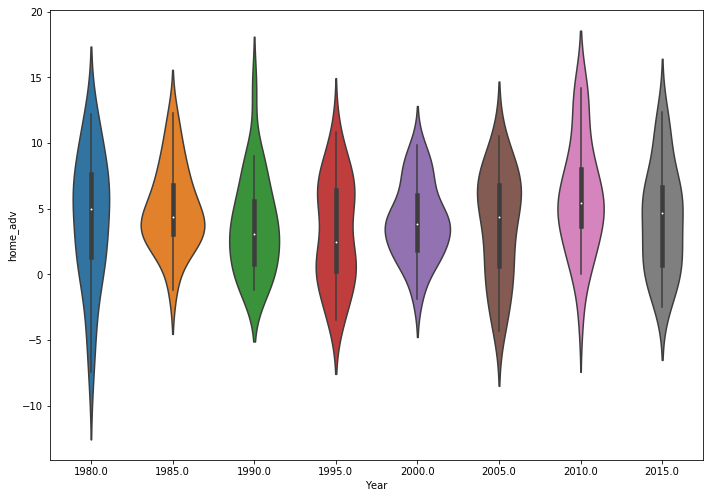

In [220]:
#ggplot(aes(x='Year', y='home_adv'), data=combined_table) +\
#    geom_violin() +\
#    labs(title="Home Field Advantage of MLB teams over time",
#         x = "Year",
#         y = "Home Advantage")
increments = ['1980', '1985', '1990', '1995', '2000', '2005', '2010', '2015']
table_five_years = combined_table.loc[combined_table['Year'].isin(increments)]
table_five_years
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.violinplot(ax=ax, x=table_five_years['Year'], y=table_five_years['home_adv'])

The violin plot more clearly shows the distribution of values for each year by displaying the density of each by the width of the "violin" at that point.  We can see that, aside from 1995, most years show unimodal distribution between the 3 and 7 home advantage values.  Moreover, year does not seem to have a clear statistical effect on home advantage based on the information we have so far.  To get a clearer sense of what's going on, let's do a few more transformations on our tables

Lest's make two more tables,  one showing the average home advantage over all mlb for each year, and one showing the average across all years for each team.  We can do this using groupby and mean aggregate functions.

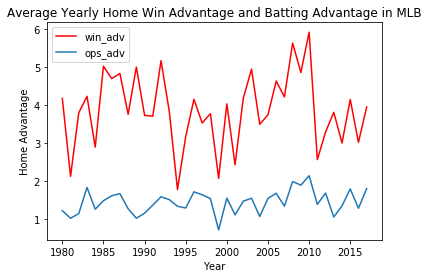

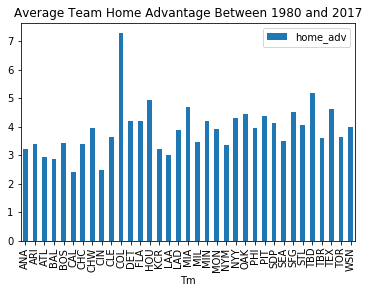

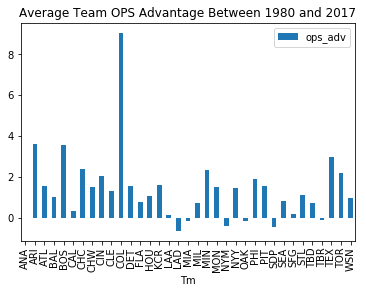

In [221]:
mlb_avg = combined_table.groupby(['Year'], as_index=False)['home_adv'].mean()
mlb_ops = combined_table.groupby(['Year'], as_index=False)['ops_adv'].mean()
mlb_avg = mlb_avg.merge(right=mlb_ops, on='Year')
team_avg = combined_table.groupby(['Tm'], as_index=False)['home_adv'].mean()
team_ops = combined_table.groupby(['Tm'], as_index=False)['ops_adv'].mean()
team_avg = team_avg.merge(right=team_ops, on='Tm')
plt.plot(mlb_avg['Year'], mlb_avg['home_adv'], 'r-', label='win_adv')
plt.plot(mlb_avg['Year'], mlb_avg['ops_adv'], label='ops_adv')
plt.xlabel('Year')
plt.ylabel('Home Advantage')
plt.title('Average Yearly Home Win Advantage and Batting Advantage in MLB')
plt.legend()
plt.show()
team_avg.plot(x='Tm', y='home_adv', kind='bar', title='Average Team Home Advantage Between 1980 and 2017')
team_avg.plot(x='Tm', y='ops_adv', kind='bar', title='Average Team OPS Advantage Between 1980 and 2017')

The two plots allow us to make a few obervations.  First, we see that from year to year there is a lot of variation in MLB average home advantage.  This suggests that time doesn't play a significant role in determing or predicting home advantage across the major league.

Second, we can see at a glance from the bar chart which teams seem to benefit the most from playing in their home park.  With Colorado, Houston, and Tamba Bay taking the top 3 spots in terms of win advantage.  We also see that despite the home advantage strongly correlating with improved chances of winning, the home affect on the important offensive stat, ops, is much more less pronounced except in the case of the Colorado Rockies.

From here, we can start investigating why certain teams seem to have more distinct home advantages compared to others.  Intuitively, we should be able to measure what affects home advantage more easily than what affects a teams overall performance.  This is because while teams cycle through players of varying quality each year, the difference in conditions between home games and away games remain relatively constant except for a few factors.  Looking at the difference between Colorado and the rest of the league's home advantage scores hints at one possible avenue of investigation.  That is, the affects of location and climate one home advantage.

The Colorado Rockies are known for having a unique home field, in that it sits at the highest elevation of any major league ballpark.  This means that the atmosphere at the park is thinner, and that balls tend travel farther off the bat as a result (read more on this here https://en.wikipedia.org/wiki/Coors_Field#Reputation_as_a_home_run-friendly_park).  This is evidenced by the high OPS advantage indicated for Colorado in our data.  However, although you would expect both the home and away teams to benefit equally from this condition, the Rockies still tend to fair much betterat home in terms of wins and losses.  This could suggest that playing, practicing, and conditioning on the same field provides tangible benefits to a team's success at that field, but does this hold true for parks in climates that aren't as unique as Coor's Field?

To explore this, lets gather some location data for each team and include it in our table of team averages.

In [222]:
#associate team with park coordinates.  Modified a json file
# from https://gist.github.com/the55/2155142 by changing team names
# to codes in dataframe and adding teams that no longer exist but are
#listed in original datafram
locations = pd.read_json('locations.json')
locations = locations.append({'team':'MIA', "lat": 25.954428, "lng":-80.238164}, ignore_index=True)
locations = locations.append({'team':'CAL', "lat": 33.799572, "lng":-117.889031}, ignore_index=True)
locations.columns = ['lat', 'lng', 'Tm']
team_avg = team_avg.merge(right=locations, on='Tm')
team_avg.head()

,Tm,home_adv,ops_adv,lat,lng
0,ANA,3.223803,-0.025000,33.799572,-117.889031
1,ARI,3.395062,3.640000,33.452922,-112.038669
2,ATL,2.924131,1.539474,33.746910,-84.391239
3,BAL,2.871430,1.005263,39.285243,-76.620103
4,BOS,3.436248,3.550000,42.346613,-71.098817


We can now try building a folium map using these coordinates and visualizing the team home advantage with the size of our markers. If you're unfamilliar with folium maps you can read up on them here https://folium.readthedocs.io/en/latest/